#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# this notebook is for a lower dimension of X, Z and φ, ψ only 
# (i.e. surge, heave and roll, yaw) 

In [2]:
# TODO: It seems that the model is doing just a parallel translation of coordinates?

In [3]:
# import julia;
# julia.install()

In [4]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [5]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [6]:
# from diffeqpy import ode
# from diffeqpy import de

In [7]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [8]:
from sympy import *

In [9]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [10]:
mp = 96 #  (submerged) [kg/m]

In [11]:
node_N=4

In [12]:
diag_Irho = 1e2*np.array([1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.],
       [  0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. ],
       [0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1]) # [Nm2] p. 4721 in [3]

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00],
       [0.e+00, 1.e+09]])

In [21]:
def Re_t_(arr):
    φ,ψ=arr[0],arr[1]
  
    Cφ=np.matrix([[1,0], [0,np.cos(φ)]])

    Cψ=np.matrix([[np.cos(ψ),0], [0,1]])
        

    return np.array(np.dot(Cφ,Cψ) )

In [22]:
Re_t_([3,5])

array([[ 0.28366219,  0.        ],
       [ 0.        , -0.9899925 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ,ψ = rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
ψ

array([-1.61198331,  0.41540219, -1.46148375,  1.10504909])

In [26]:
def Re_t(a,c):
    xz=np.stack((a,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xz)

In [27]:
Re_t_([φ[0],ψ[0]])

array([[-0.04117533,  0.        ],
       [ 0.        , -0.46335829]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,ψ)
print(datetime.now() - startTime1)

0:00:00.005191


In [29]:
Ret

array([[[-0.04117533,  0.        ],
        [ 0.        , -0.46335829]],

       [[ 0.91495409,  0.        ],
        [ 0.        ,  0.93242307]],

       [[ 0.109095  ,  0.        ],
        [ 0.        ,  0.42396391]],

       [[ 0.44909057,  0.        ],
        [ 0.        ,  0.08625783]]])

In [30]:
Ret.shape

(4, 2, 2)

In [31]:
dx,dz=rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx, dz, Ret):
    B=np.vstack([dx**2,(dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
#     print(B.shape, Ret.shape)
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([0.01856575, 0.26146802, 0.00991517, 0.02472574])

In [34]:
C1(dx,dz,Ret)

array([[-7.64451072e-04,  2.39231234e-01,  1.08169498e-03,
         1.11040989e-02],
       [ 3.56414897e-02, -2.25688747e+00, -2.36431449e-01,
         4.62478688e-02]])

In [35]:
C1(dx,dz,Ret).shape

(2, 4)

In [36]:
startTime1 = datetime.now()
C1(dx,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000420


In [37]:
def fD(dx,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dz,Ret))*9.81

In [38]:
1/2*d0*qw*np.dot(DT,C1(dx,dz,Ret).T[0])*9.81

array([ -4.38721065, 204.547719  ])

In [39]:
fD(dx,dz,DT,Ret)

array([[-4.38721065e+00,  1.37295617e+03,  6.20788419e+00,
         6.37268007e+01],
       [ 2.04547719e+02, -1.29523538e+04, -1.35688811e+03,
         2.65418089e+02]])

In [40]:
fD(dx,dz,DT,Ret).T

array([[-4.38721065e+00,  2.04547719e+02],
       [ 1.37295617e+03, -1.29523538e+04],
       [ 6.20788419e+00, -1.35688811e+03],
       [ 6.37268007e+01,  2.65418089e+02]])

In [41]:
startTime1 = datetime.now()
fD(dx,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000683


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
I=np.identity(2)

In [44]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000518


In [45]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [46]:
Rb_t

array([[1., 0.],
       [0., 1.]])

In [47]:
diag_DR = 1.5*np.array([1,  1]) # [N m/rad]  p.4721 in [3]

In [48]:
DR=np.diag(diag_DR) 

In [49]:
dI= 0.69# Inner diameter of pipe, [m]

In [50]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [51]:
Ar

0.08091250419136858

In [52]:
fg_e=np.array([[0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [53]:
fg_e

array([[  0.        , 128.16454223],
       [  0.        , 128.16454223],
       [  0.        , 128.16454223],
       [  0.        , 128.16454223]])

In [54]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [55]:
x,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [56]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [57]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [58]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [59]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [60]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [61]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [62]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000106


In [64]:
def phi(x, z, Ret):
    B=np.vstack([x,z])
    return np.einsum('ijk,ik->ij', Ret,B.T)

In [65]:
phi(x,z,Ret)

array([[  0.9015394 , -35.039226  ],
       [-35.37131334,   1.17064293],
       [ -8.17494663, -40.10367141],
       [-47.32866796,  -1.00279996]])

In [66]:
startTime1 = datetime.now()
phi(x,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000254


In [67]:
# def d_s(da,dc,x,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(dc,prepend=dc[0])/ds])
def d_s(f,a,c,Ret):
    ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
    ds[ds == 0] = 1
    fun = f(a,c,Ret)
    ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
    return ans

In [68]:
startTime1 = datetime.now()
d_s(phi,x,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000422


In [69]:
d_s(phi,x,z,Ret)

array([[ 0.        , -0.47582935,  0.26537578, -0.4430199 ],
       [ 0.        ,  0.47500312, -0.4027451 ,  0.44242191]])

In [70]:
# def ne(x,z,Ret):
#     A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(x,z,x,z).T
#     return np.einsum('ijk,ik->ij', A,B)

def ne(x,z,Ret):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,z,Ret).T
    return np.einsum('ijk,ik->ij', A,B)

In [71]:
def ne_(dx,dz,DT,Ret):
    return -fg_e.T-fD(dx,dz,DT,Ret) #-sigma(x,y,z).T

In [72]:
# sigma(x,y,z)

In [73]:
ne_(dx,dz,DT,Ret)

array([[ 4.38721065e+00, -1.37295617e+03, -6.20788419e+00,
        -6.37268007e+01],
       [-3.32712261e+02,  1.28241892e+04,  1.22872357e+03,
        -3.93582631e+02]])

In [74]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [75]:
startTime1 = datetime.now()
ne(x,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000392


In [76]:
startTime1 = datetime.now()
ne_(dx,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000233


In [77]:
Re_b(Ret).shape

(4, 2, 2)

In [78]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [79]:
Irho_e(Ret)

array([[[1.69540817e-01, 0.00000000e+00],
        [0.00000000e+00, 4.29401818e+01]],

       [[8.37140980e+01, 0.00000000e+00],
        [0.00000000e+00, 1.73882556e+02]],

       [[1.19017194e+00, 0.00000000e+00],
        [0.00000000e+00, 3.59490787e+01]],

       [[2.01682344e+01, 0.00000000e+00],
        [0.00000000e+00, 1.48808257e+00]]])

In [80]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000254


In [81]:
def Π_(arr):
    φ,ψ=arr[0],arr[1]
    return np.array([[np.cos(ψ),0], [0,1]])

In [82]:
def Π(a,c):
    xz=np.stack((a,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xz)
    

In [83]:
startTime1 = datetime.now()
Π(φ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000519


In [84]:
Π(φ,ψ)

array([[[-0.04117533,  0.        ],
        [ 0.        ,  1.        ]],

       [[ 0.91495409,  0.        ],
        [ 0.        ,  1.        ]],

       [[ 0.109095  ,  0.        ],
        [ 0.        ,  1.        ]],

       [[ 0.44909057,  0.        ],
        [ 0.        ,  1.        ]]])

In [85]:
# def ωe(φ,ψ,x,z):  # (100) in [2]
#     A=Π(φ,ψ)
# #     print(ψ.shape)
#     B=d_s(φ,ψ,x,z).T

#     return np.einsum('ijk,ik->ij', A,B) 
def ωe(φ,ψ, dummy):  # (100) in [2]
    A=Π(φ,ψ)
    B=np.vstack([φ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T)

In [86]:
startTime1 = datetime.now()
ωe(φ,ψ,None)
print(datetime.now() - startTime1)

0:00:00.002326


In [87]:
ωe(φ,ψ,None)

array([[ 0.08451556, -1.61198331],
       [-0.33829073,  0.41540219],
       [ 0.12360232, -1.46148375],
       [ 0.66664405,  1.10504909]])

In [88]:
diag_CR = 1e11*np.array([1,  1]) 
CR=np.diag(diag_CR)

In [89]:
CR

array([[1.e+11, 0.e+00],
       [0.e+00, 1.e+11]])

In [90]:
# def me(φ,ψ,x,z,Ret):
#     A=np.multiply(np.multiply(Ret,CR),Ret)
#     B=ωe(φ,ψ,x,z)
#     return np.einsum('ijk,ik->ij', A,B) 
def d_me(φ,ψ,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(ωe,φ,ψ,None)
    return np.einsum('ijk,ik->ij', A,B.T)

In [91]:
startTime1 = datetime.now()
me_=d_me(φ,ψ,Ret)
print(datetime.now() - startTime1)

0:00:00.000910


In [92]:
me_

array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.34335230e+10,  6.68978607e+10],
       [ 2.28641616e+08, -1.40313610e+10],
       [ 4.22785512e+09,  7.37161885e+08]])

In [93]:
diag_DR = 1.5*np.array([1,  1]) 
 
DR=np.diag(diag_DR)

In [94]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [95]:
ne_(dx,dz,DT,Ret)

array([[ 4.38721065e+00, -1.37295617e+03, -6.20788419e+00,
        -6.37268007e+01],
       [-3.32712261e+02,  1.28241892e+04,  1.22872357e+03,
        -3.93582631e+02]])

In [96]:
C=ne(x,z,Ret)
  
a,c=C[:,0],C[:,1],

In [97]:
Re_b(Ret).shape

(4, 2, 2)

In [98]:
ne_(dx,dz,DT, Ret).T

array([[ 4.38721065e+00, -3.32712261e+02],
       [-1.37295617e+03,  1.28241892e+04],
       [-6.20788419e+00,  1.22872357e+03],
       [-6.37268007e+01, -3.93582631e+02]])

In [99]:
ne_(dx,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dz,DT,Ret).T)

array([[ 4.20656578e+00, -1.78547275e+02],
       [-2.62914803e+03,  2.47817591e+04],
       [-6.88513332e+00,  1.74965801e+03],
       [-9.23459062e+01, -4.27532214e+02]])

In [100]:
ne_(dx,dz,DT,Ret).T

array([[ 4.38721065e+00, -3.32712261e+02],
       [-1.37295617e+03,  1.28241892e+04],
       [-6.20788419e+00,  1.22872357e+03],
       [-6.37268007e+01, -3.93582631e+02]])

### Vessel

In [101]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
    
        self.G=np.delete(self.G,(1,4), axis=0)
        self.G=np.delete(self.G,(1,4), axis=1)
        
        self.M =np.delete(self.M ,(1,4), axis=0)
        self.M =np.delete(self.M ,(1,4), axis=1)
        
        self.D =np.delete(self.D,(1,4), axis=0)
        self.D =np.delete(self.D ,(1,4), axis=1)
        

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [102]:
V=VesselSemisub()

In [103]:
η=np.array([0.1,0.4,.34,0.7])
dη=np.array([0,0,0,0])
ddη=np.array([0,0,0,0])

In [104]:
tau_force = V.tau(η,dη, ddη)

In [105]:
tau_force

array([0.00000e+00, 2.40000e+06, 4.86064e+09, 0.00000e+00])

In [106]:
# class VesselOtter: 
    
#     def __init__(
#         self, 
#         controlSystem="stepInput", 
#         r = 0, 
#         V_current = 0, 
#         beta_current = 0,
#         tau_X = 120
#     ):
        
#         # Constants
#         D2R = math.pi / 180     # deg2rad
#         self.g = 9.81           # acceleration of gravity (m/s^2)
#         rho = 1026              # density of water (kg/m^3)

#         if controlSystem == "headingAutopilot":
#             self.controlDescription = (
#                 "Heading autopilot, psi_d = "
#                 + str(r)
#                 + " deg"
#                 )
#         else:
#             self.controlDescription = "Step inputs for n1 and n2"
#             controlSystem = "stepInput"

#         self.ref = r
#         self.V_c = V_current
#         self.beta_c = beta_current * D2R
#         self.controlMode = controlSystem
#         self.tauX = tau_X  # surge force (N)

#         # Initialize the Otter USV model
#         self.T_n = 1.0  # propeller time constants (s)
#         self.L = 2.0    # Length (m)
#         self.B = 1.08   # beam (m)
#         self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
#         self.u_actual = np.array([0, 0], float)  # propeller revolution states
#         self.name = "Otter USV (see 'otter.py' for more details)"

#         self.controls = [
#             "Left propeller shaft speed (rad/s)",
#             "Right propeller shaft speed (rad/s)"
#         ]
#         self.dimU = len(self.controls)

#         # Vehicle parameters
#         m = 55.0                                 # mass (kg)
#         self.mp = 25.0                           # Payload (kg)
#         self.m_total = m + self.mp
#         self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
#         rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
#         rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
#         self.S_rg = Smtrx(rg)
#         self.H_rg = Hmtrx(rg)
#         self.S_rp = Smtrx(self.rp)

#         R44 = 0.4 * self.B  # radii of gyration (m)
#         R55 = 0.25 * self.L
#         R66 = 0.25 * self.L
#         T_yaw = 1.0         # time constant in yaw (s)
#         Umax = 6 * 0.5144   # max forward speed (m/s)

#         # Data for one pontoon
#         self.B_pont = 0.25  # beam of one pontoon (m)
#         y_pont = 0.395      # distance from centerline to waterline centroid (m)
#         Cw_pont = 0.75      # waterline area coefficient (-)
#         Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

#         # Inertia dyadic, volume displacement and draft
#         nabla = (m + self.mp) / rho  # volume
#         self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
#         Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
#         self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

#         # Experimental propeller data including lever arms
#         self.l1 = -y_pont  # lever arm, left propeller (m)
#         self.l2 = y_pont  # lever arm, right propeller (m)
#         self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
#         self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
#         self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
#         self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

#         # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
#         #               O3       Ig ]
#         MRB_CG = np.zeros((6, 6))
#         MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
#         MRB_CG[3:6, 3:6] = self.Ig
#         MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

#         # Hydrodynamic added mass (best practice)
#         Xudot = -0.1 * m
#         Yvdot = -1.5 * m
#         Zwdot = -1.0 * m
#         Kpdot = -0.2 * self.Ig[0, 0]
#         Mqdot = -0.8 * self.Ig[1, 1]
#         Nrdot = -1.7 * self.Ig[2, 2]

#         self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

#         # System mass matrix
#         self.M = MRB + self.MA
#         self.Minv = np.linalg.inv(self.M.astype(np.float32))

#         # Hydrostatic quantities (Fossen 2021, Chapter 4)
#         Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
#         I_T = (
#             2
#             * (1 / 12)
#             * self.L
#             * self.B_pont ** 3
#             * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
#             + 2 * Aw_pont * y_pont ** 2
#         )
#         I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
#         KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
#         BM_T = I_T / nabla  # BM values
#         BM_L = I_L / nabla
#         KM_T = KB + BM_T    # KM values
#         KM_L = KB + BM_L
#         KG = self.T - rg[2]
#         GM_T = KM_T - KG    # GM values
#         GM_L = KM_L - KG

#         G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
#         G44 = rho * self.g * nabla * GM_T
#         G55 = rho * self.g * nabla * GM_L
#         G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
#         LCF = -0.2
#         H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
#         self.G = H.T @ G_CF @ H

#         # Natural frequencies
#         w3 = math.sqrt(G33 / self.M[2, 2])
#         w4 = math.sqrt(G44 / self.M[3, 3])
#         w5 = math.sqrt(G55 / self.M[4, 4])

#         # Linear damping terms (hydrodynamic derivatives)
#         Xu = -24.4 *self. g / Umax  # specified using the maximum speed
#         Yv = 0
#         Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
#         Kp = -2 * 0.2 * w4 * self.M[3, 3]
#         Mq = -2 * 0.4 * w5 * self.M[4, 4]
#         Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

#         self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

#         # Propeller configuration/input matrix
#         B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
#         self.Binv = np.linalg.inv(B.astype(np.float32))

#         # Heading autopilot
#         self.e_int = 0  # integral state
#         self.wn = 1.2  # PID pole placement
#         self.zeta = 0.8

#         # Reference model
#         self.r_max = 10 * math.pi / 180  # maximum yaw rate
#         self.psi_d = 0  # angle, angular rate and angular acc. states
#         self.r_d = 0
#         self.a_d = 0
#         self.wn_d = self.wn / 5  # desired natural frequency in yaw
#         self.zeta_d = 1  # desired relative damping ratio
    
    
#     def eq_left(self,η, dη):
        
#         CRB_CG = np.zeros((6, 6))
#         CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
#         CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
#         CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

#         CA = m2c(self.MA, dη)
#         CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
#         CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
#         CA[0, 5] = 0
#         CA[1, 5] = 0

#         C = CRB + CA

#         return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
#     def tau(self,η, dη, ddη):

        
#         CRB_CG = np.zeros((6, 6))
#         CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
#         CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
#         CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

#         CA = m2c(self.MA, dη)
#         CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
#         CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
#         CA[0, 5] = 0
#         CA[1, 5] = 0

#         C = CRB + CA
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [107]:
# V=VesselOtter()

In [108]:
# η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
# dη=np.array([0,0,0,0,0,0])
# ddη=np.array([0,0,0,0,0,0])

In [109]:
# tau_force = V.tau(η,dη, ddη)

In [110]:
# tau_force

In [111]:
# np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

In [112]:
# V=VesselSemisub()

In [113]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
# kp, kd=1.95e9,1.5e9
kp,kd=1.95e4, 1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [114]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [115]:
Hs = 2.5 # significant wave height in m

In [116]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [117]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [118]:
η

array([0.1 , 0.4 , 0.34, 0.7 ])

In [119]:
Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0)

array([ 428998.9259107 ,  761522.79365828, 1462710.51710561,
       2057420.77785615])

In [120]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,z,φ,ψ=η
    dx,dz,dφ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),
                 0])+wave_coef*np.array([0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)).T
    Ret=Re_t_([φ,ψ])
    tmp=np.dot(Re_b(Ret), F)
    return  np.concatenate([tmp.tolist(),[0,0]], axis=0)

In [121]:
tau(η, dη, wave_coef, kp, kd,3)

array([1491.4422652 , 6866.71557051,    0.        ,    0.        ])

### Static solution

In [122]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [123]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [124]:
Fx_0=82945396

In [125]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [126]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [127]:
delta_x=horizontal_length/(node_N-1)

In [128]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [129]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

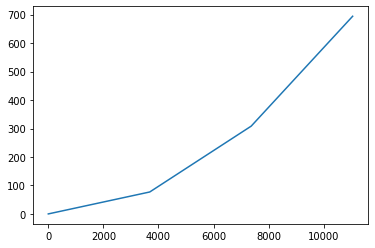

In [130]:
plt.plot(x0, z0)
plt.show()

In [131]:
rng = np.random.default_rng()
q0=np.zeros(8*node_N)

In [132]:
for j in range(1,8):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==3:    
        q0[(j-1)*node_N:j*node_N]=z0

In [133]:
q0.shape

(32,)

In [134]:
def static_func(Q):
    t=0
 
    x,z=Q[0:node_N],Q[2*node_N:3*node_N]
    dx,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N]
    φ,ψ=Q[4*node_N:5*node_N],Q[6*node_N:7*node_N]
    Ret = Re_t(φ,ψ)
    dφ,dψ=Q[5*node_N:6*node_N],Q[7*node_N:8*node_N]
    
    η=[x[-1],z[-1],φ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0])

    
    
    C=ne(x,z,Ret)
    a,c=C[:,0],C[:,1],

#     Z0=tau_force[:2]
    Z0=np.dot(Re_b(Ret),tau_force[:2])
   
    Z1 = d_s(ne, x, z, Ret).T

    DT_0=np.zeros((2,2))
    Z2=ne_(dx,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi,  ddz_phi]).T)
#     ddx,  ddz = tmp[:,0],tmp[:,1]
#     tmp=phi(ddx_phi, ddz_phi, Ret)
#     ddx,  ddz = tmp[:,0],tmp[:,1]
############################################################    
   
#     d_me_=me(φ,ψ,x,z,Ret)
  
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',
                                         np.linalg.inv(Π(φ,ψ).astype(np.float32)),
                        Re_b(Ret)), tau_force[2:].reshape(2,1)) 
#     C3= d_s(me_[:,0],me_[:,1],x,z).astype(np.float32).T
    C3=d_me(φ,ψ,Ret)

    B_ =C3
#     print(C3.shape, C0.shape)
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
#     print(dx, ddx, dz, ddz, dφ, ddφ, dψ, ddψ)

    ans=np.concatenate([dx, ddx, dz, ddz, dφ, ddφ, dψ, ddψ], axis=0)
#     print(ans.shape)
 
    return ans
    

In [135]:
q0.shape

(32,)

In [136]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [137]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [138]:
x0_,z0_=root[:node_N],root[2*node_N:3*node_N]

In [139]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [140]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [141]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [142]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

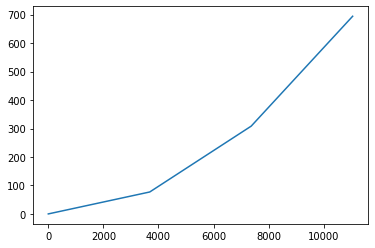

In [143]:
plt.plot(x0_, z0_)
plt.show()

In [144]:
for j in range(1,8):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==3:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [145]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

### Dynamics

In [146]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     print(t)
     
    x,z=Q[0:node_N],Q[2*node_N:3*node_N]
#     x[0]=0
#     z[0]=0

    dx,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N]
    
#     dx[0]=0
#     dz[0]=0

    φ,ψ=Q[4*node_N:5*node_N],Q[6*node_N:7*node_N]
    
    Ret = Re_t(φ,ψ)

    dφ,dψ=Q[5*node_N:6*node_N],Q[7*node_N:8*node_N]
    
    η=[x[-1],z[-1],φ[-1],ψ[-1]]
    dη=[dx[-1],dz[-1],dφ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)

    # PD controller after 20 sec
#     if t<20:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:
    hack =1
    ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, -left.astype(np.float32) 
                    + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                        , rcond=None)[0]
#     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)

#     C=ne(x,z,Ret)

  
#     a,c=C[:,0],C[:,1]
#     Z0=tau_force[:3]
#     Z0=tau_force[:2]
#     Z0=np.dot(Re_b(Ret),tau_force[:2])
   
    Z1 = d_s(ne, x, z, Ret).T

    Z2=ne_(dx,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
#         +
#         Z0
       )

     
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,c=np.linalg.lstsq(Ws*RRRR[i], Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_z.append(c)
    
    ddx, ddz = np.array(ans_x),np.array(ans_z) 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi,  ddz_phi]).T)
#     ddx,  ddz = tmp[:,0],tmp[:,1]
    
 
    
#     d_me_=me(φ,ψ,x,z,Ret)

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,ψ).astype(np.float32),np.array([dφ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,ψ).astype(np.float32),np.array([dφ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,ψ).astype(np.float32),np.array([dφ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,ψ).astype(np.float32),
                                     np.array([dφ,dψ]).astype(np.float32).T)))
#     print(C2.shape)

#     C3= d_s(me_[:,0],me_[:,1],x,z).astype(np.float32).T
    C3=d_me(φ,ψ,Ret)

#     C4= np.cross(d_s(x,z,x,z).T,ne(x,z,Ret))
    C4= np.cross(d_s(phi,x,z,Ret).T, ne(x,z,Ret))

    K1=np.einsum('ijk,ik->ij',Π(φ,ψ).astype(np.float32),np.array([dφ,dψ]).astype(np.float32).T).T

    C5= -np.dot(DR,K1).astype(np.float32).T
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,ψ)), tau_force[2:].reshape(2,1)
#                 ) 
#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',
#                                          np.linalg.inv(Π(φ,ψ).astype(np.float32)),
#                         Re_b(Ret)), tau_force[2:].reshape(2,1))
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
         -C2.reshape(node_N,1)
         +C3
        +C4.reshape(node_N,1)
        +C5
    )
#     B= B_ +C0.squeeze()
    B= B_ 

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_ψ.append(c)
    
    ddφ,ddψ=np.array(ans_φ),np.array(ans_ψ)

    ddx[-1],ddz[-1],ddφ[-1],ddψ[-1]=ddη
    ddx[0],ddz[0],ddφ[0],ddψ[0]=0,0,0,0
    A1111=np.concatenate([dx, ddx, dz, ddz, dφ, ddφ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [147]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [148]:
tspan = (0., 5)

In [149]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

4:25:43.360036


In [150]:
fin=us

In [151]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [152]:
fin

  message: 'Required step size is less than spacing between numbers.'
     nfev: 6182582
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 1.31714041e-07, 1.36419982e-07, ...,
       5.56483240e-05, 5.56483240e-05, 5.56483240e-05])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.68422828e+03,  3.68422828e+03,  3.68422828e+03, ...,
         3.68422828e+03,  3.68422828e+03,  3.68422828e+03],
       [ 7.36845656e+03,  7.36845656e+03,  7.36845656e+03, ...,
         7.36845656e+03,  7.36845656e+03,  7.36845656e+03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.94943677e-01, -3.94943677e-01, -3.94943677e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -6.80279892e-02, -6.79943802e-02, -6.76685328e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.0000000

In [153]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


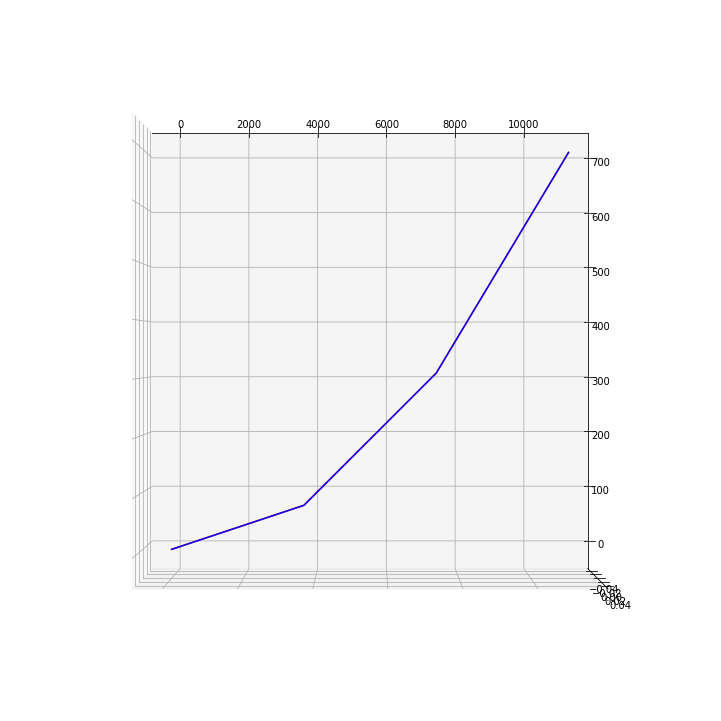

In [154]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Z0=fin[0,[i for i in range(2*node_N,3*node_N)]]
# Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Z=fin[j,[i for i in range(2*node_N,3*node_N)]]
# Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Z0, color='r')
ax.plot(X,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [155]:
X,Z

(array([    0.        ,  3684.22828193,  7368.45656297, 11052.68484447]),
 array([  0.        ,  77.06804646, 308.40705931, 694.42189497]))

In [156]:
X0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [157]:
us=fin.T

In [158]:
t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

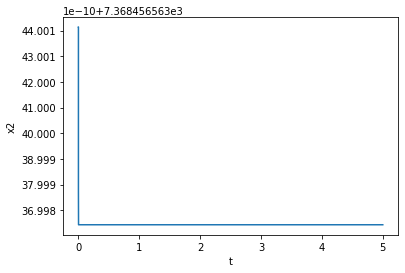

In [159]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

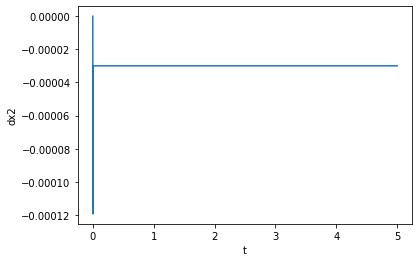

In [160]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

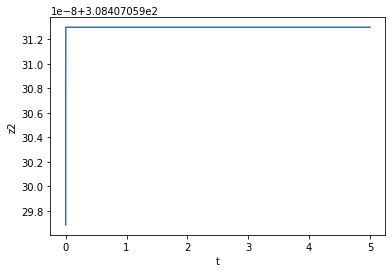

In [161]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

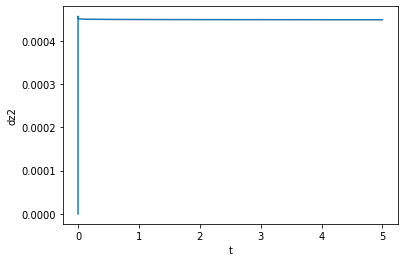

In [162]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

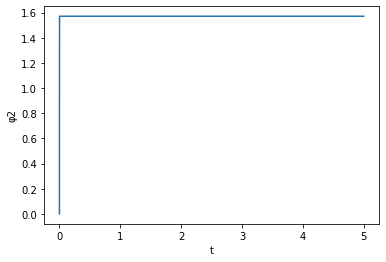

In [163]:
plt.plot(t,us.T[:,18],'-')
plt.xlabel('t')
plt.ylabel('φ2')
plt.show()

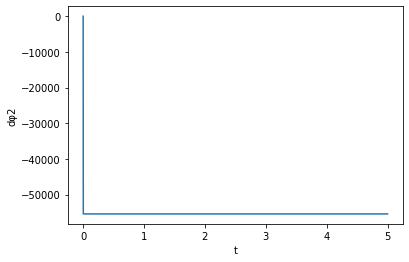

In [164]:
plt.plot(t,us.T[:,21] ,'-')
plt.xlabel('t')
plt.ylabel('dφ2')
plt.show()

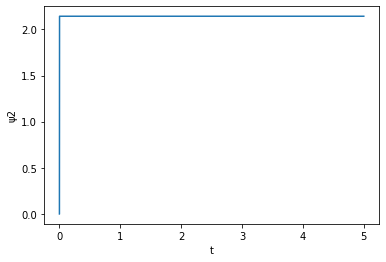

In [165]:
plt.plot(t,us.T[:,26],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

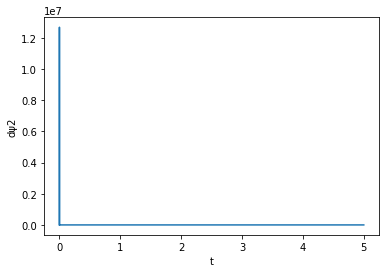

In [166]:
plt.plot(t,us.T[:,30] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()